# Skenario 13 LSTM : Weekly Dataset - One Feature With One Feature

In [1]:
import pandas as pd
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from matplotlib import pyplot as plt

import numpy as np
import random as rn
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from math import sqrt

import sys, time
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras import optimizers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import RandomUniform
from tensorflow.keras.models import load_model

In [2]:
# Setting seed to ensure reproducibility.
rn.seed(14)
np.random.seed(14)
tf.random.set_seed(14)

# visual formating the graph
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 15

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)    # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.style.use(['seaborn-whitegrid'])
plt.rcParams.update({'figure.figsize':(10,5), 'figure.dpi':120})
plt.rcParams['font.family'] = 'cambria'

In [3]:
# date-time parsing function for loading the dataset
def parser(X):
    return pd.to_datetime(X, format = '%Y-%m-%d')


# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
    df = DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = concat(columns, axis=1)
    df.fillna(0, inplace=True)
    return df

# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

# scale train and test data to [-1, 1]
def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled

# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
    new_row = [x for x in X] + [value]
    array = np.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]

# fit a LSTM network to training data
def fit_LSTM(train, batch_size, nb_epoch, neurons):
    # Define Input shape
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    
    # weight and biases initialization
    init = RandomUniform(minval=0, maxval=1)
    
    # Define Model
    model = Sequential()
    model.add(LSTM(units=neurons,
                  use_bias=True,
                  activation='tanh',
                  recurrent_activation='sigmoid',
                  batch_input_shape=(batch_size, X.shape[1], X.shape[2]),
                  kernel_initializer=init,
                  bias_initializer=init,
                  recurrent_initializer=init))
    model.add(Dense(units=1,activation='tanh',
                    use_bias=True,
                    kernel_initializer=init,
                    bias_initializer=init))
    model.compile(loss='mean_squared_error', 
                  optimizer='adam', 
                  clipvalue=0.5)
    
    # configure early stopping
    es = EarlyStopping(monitor='val_loss',  
                       mode='auto',
                       min_delta=0,
                       verbose=1, 
                       patience=2)
    
    # summarize the model
    print(model.summary())
    
    plot_model(model, 'model-W11.png', show_shapes=True)
    
    # start counting training time
    start = time.time()
    
    # Fit the model
    history = model.fit(X, y,
                        epochs=nb_epoch,
                        batch_size=batch_size,
                        verbose=0, validation_data=(X, y),
                        callbacks=[es], shuffle=False)
        
    # finished calculating training time
    end = time.time()
    print("Time Took :{:3.2f} min".format( (end-start)/60 ))
  
    # plot learning curves
    plt.title('Learning Curves')
    plt.xlabel('Epoch')
    plt.ylabel('MSE')
    plt.plot(history.history['loss'], label='train',color='#073763ff')
    plt.plot(history.history['val_loss'], label='val',color='tab:red')
    plt.legend()
    plt.show()
    
    # save model and architecture to single file
    model.save('model-W11.h5')
    
    return model

# make a one-step forecast
def forecast_LSTM(model, batch_size, X):
    X = X.reshape(1, 1, len(X))
    yhat = model.predict(X, batch_size=batch_size)
    return yhat[0,0]

# visualize the dataset
def plot_series(series):
    plt.plot(series,color ='#073763ff')
    plt.ylabel('Number Of Tourist',fontsize=15)
    plt.xlabel('Time',fontsize=15)
    plt.title("Weekly Visitors to TNGMb in 2013 - 2018",fontsize=20)
    plt.show()
    
# visualize the dataset after make dataset stationary    
def plot_stationary(diff_values):
    plt.plot(diff_values,color='#073763ff')
    plt.gca().set(title = "Transform data to be stationary with Differencing" , 
                  xlabel='Week + i', 
                  ylabel='#Tourist',)
    plt.show()
    plt.hist(diff_values,color='#073763ff')
    plt.gca().set(title = "Histogram Of Stationary  Data With Differencing" , 
                  xlabel='Value Ditribution', 
                  ylabel='Frequenzy')
    plt.show()
    diff_values.describe()

In [4]:
series=read_csv('02-02 TNGMb-Weekly.csv', 
                header=0,
                parse_dates=[0], 
                index_col=0,
                squeeze=True,
                date_parser=parser)

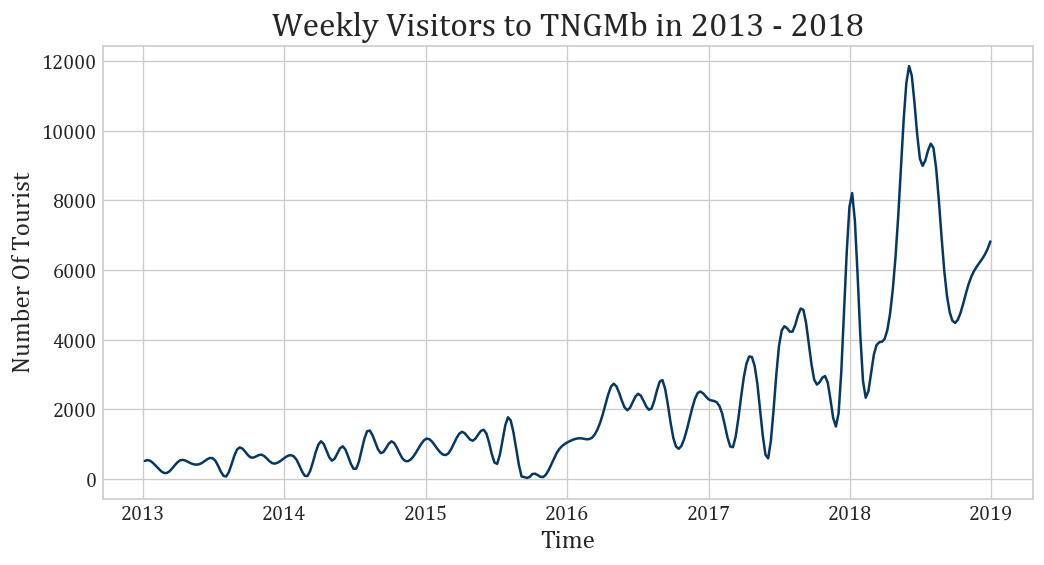

In [5]:
plot_series(series)

In [6]:
# transform data to be stationary
raw_values = series.values
diff_values = difference(raw_values, 1)

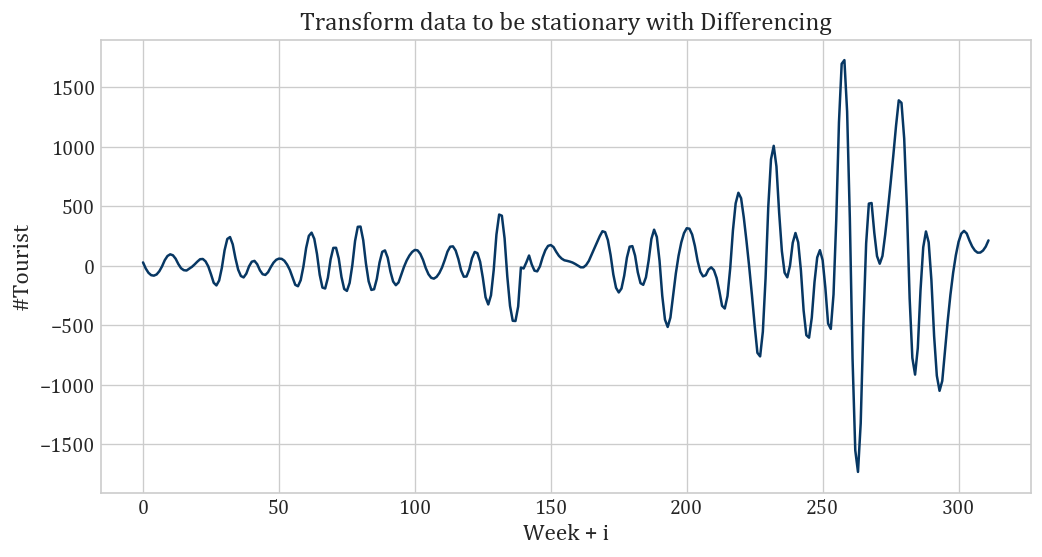

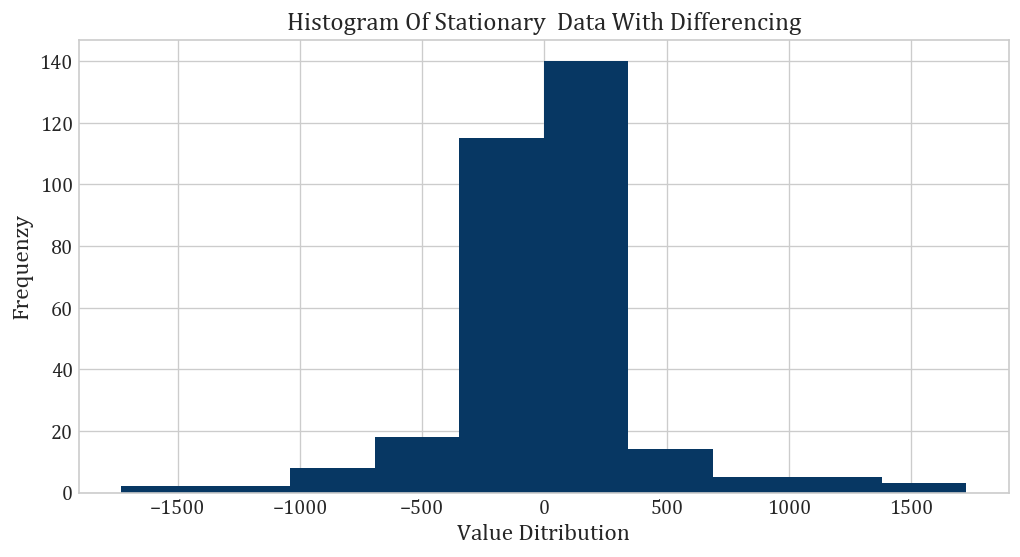

In [7]:
plot_stationary(diff_values)

In [8]:
# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values
print('Time series data point dimensions : %d Sample, %d Feature ' % supervised_values.shape)
print('---------------------------------------------------------------------------')
pd.DataFrame(supervised).head(5)

Time series data point dimensions : 312 Sample, 2 Feature 
---------------------------------------------------------------------------


,0,0
0,0.0,27
1,27.0,-24
2,-24.0,-60
3,-60.0,-80
4,-80.0,-84


In [9]:
# split data into train and test
train, test = supervised_values[0:-52], supervised_values[-52:]

# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)

In [10]:
print('Train sample & Data Dimention : %d Sample, %d Feature ' % train_scaled.shape)
print('---------------------------------------------------------------------------')
pd.DataFrame(train_scaled).tail(5)

Train sample & Data Dimention : 260 Sample, 2 Feature 
---------------------------------------------------------------------------


,0,1
255,-0.581994,-0.082797
256,-0.082797,0.579582
257,0.579582,0.975080
258,0.975080,1.000000
259,1.000000,0.652733


In [11]:
print('Test sample data point dimensions : %d Sample, %d Feature ' % test_scaled.shape)
print('---------------------------------------------------------------------------')
pd.DataFrame(test_scaled).tail(5)

Test sample data point dimensions : 52 Sample, 2 Feature 
---------------------------------------------------------------------------


,0,1
47,-0.285370,-0.299839
48,-0.299839,-0.299035
49,-0.299035,-0.285370
50,-0.285370,-0.258842
51,-0.258842,-0.217042


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (1, 1)                    12        
_________________________________________________________________
dense (Dense)                (1, 1)                    2         
Total params: 14
Trainable params: 14
Non-trainable params: 0
_________________________________________________________________
None
Time Took :142.09 min


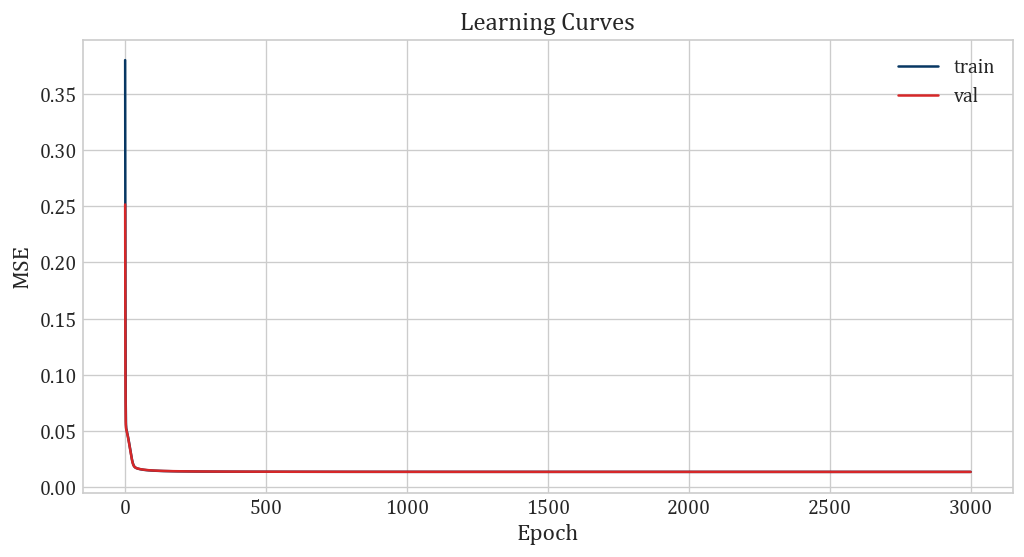

In [12]:
# fit the model
model = fit_LSTM(train_scaled, 1, 3000, 1)

In [13]:
LSTM_model = load_model('model-W11.h5')

Week=1, Predicted=600.952371, Expected=548.000000
Week=2, Predicted=665.964925, Expected=524.000000
Week=3, Predicted=630.142796, Expected=464.000000
Week=4, Predicted=563.881108, Expected=384.000000
Week=5, Predicted=449.565691, Expected=300.000000
Week=6, Predicted=285.345214, Expected=226.000000
Week=7, Predicted=120.422990, Expected=179.000000
Week=8, Predicted=20.676490, Expected=173.000000
Week=9, Predicted=48.702680, Expected=219.000000
Week=10, Predicted=243.240227, Expected=300.000000
Week=11, Predicted=525.865351, Expected=395.000000
Week=12, Predicted=816.201235, Expected=482.000000
Week=13, Predicted=1033.561007, Expected=540.000000
Week=14, Predicted=1103.309735, Expected=553.000000
Week=15, Predicted=985.435069, Expected=531.000000
Week=16, Predicted=770.857399, Expected=493.000000
Week=17, Predicted=565.238084, Expected=452.000000
Week=18, Predicted=460.709557, Expected=426.000000
Week=19, Predicted=526.431419, Expected=416.000000
Week=20, Predicted=689.220348, Expected=

Week=162, Predicted=1853.952371, Expected=1157.000000
Week=163, Predicted=1504.751882, Expected=1143.000000
Week=164, Predicted=1144.751882, Expected=1148.000000
Week=165, Predicted=906.351286, Expected=1188.000000
Week=166, Predicted=916.751445, Expected=1279.000000
Week=167, Predicted=1260.374670, Expected=1423.000000
Week=168, Predicted=1835.121682, Expected=1619.000000
Week=169, Predicted=2499.987554, Expected=1866.000000
Week=170, Predicted=3119.678954, Expected=2155.000000
Week=171, Predicted=3568.118644, Expected=2436.000000
Week=172, Predicted=3762.384934, Expected=2650.000000
Week=173, Predicted=3676.739220, Expected=2738.000000
Week=174, Predicted=3300.513069, Expected=2664.000000
Week=175, Predicted=2654.422990, Expected=2478.000000
Week=176, Predicted=1837.008219, Expected=2253.000000
Week=177, Predicted=1047.841365, Expected=2061.000000
Week=178, Predicted=515.743290, Expected=1976.000000
Week=179, Predicted=489.542300, Expected=2043.000000
Week=180, Predicted=1115.691704,

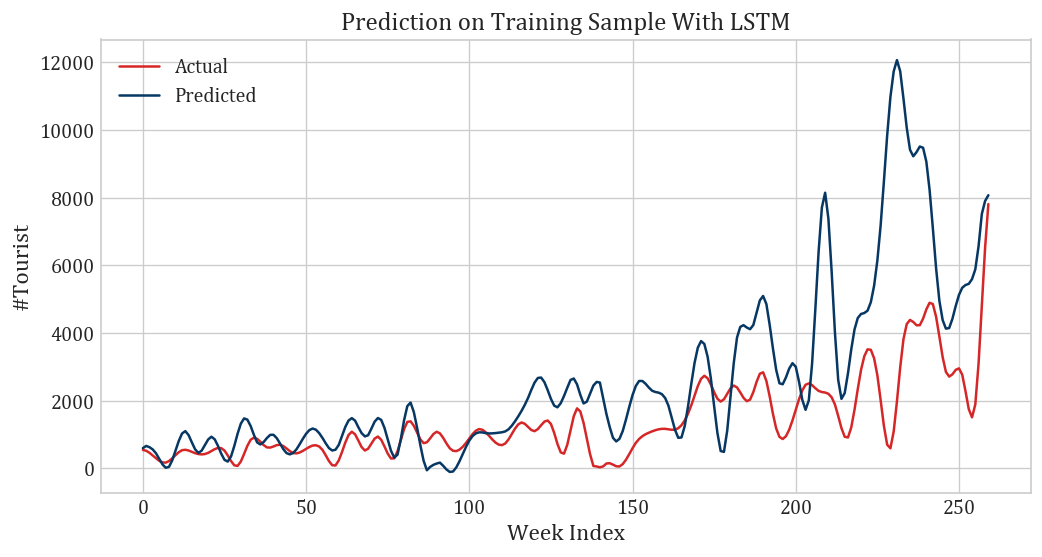

In [14]:
# walk-forward validation on the training data
predictions_train = list()
for i in range(len(train_scaled)):
    # make one-step forecast
    X, y = train_scaled[i, 0:-1], train_scaled[i, -1]
    yhat = forecast_LSTM(LSTM_model, 1, X)
    # invert scaling
    yhat = invert_scale(scaler, X, yhat)
    # invert differencing
    yhat = inverse_difference(raw_values, yhat, len(train_scaled)+1-i)
    # store forecast
    predictions_train.append(yhat)
    expected_train = raw_values[i+1]
    print('Week=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected_train))

# report performance
rmse_train = sqrt(mean_squared_error(raw_values[1:len(train_scaled)+1], predictions_train))
print('---------------------------------------------------------------------------')
print('Train RMSE: %.3f' % rmse_train)
print('---------------------------------------------------------------------------')
# line plot of observed vs predicted
plt.plot(raw_values[1:len(train_scaled)+1], label = 'Actual',color='tab:red')
plt.plot(predictions_train, label = 'Predicted',color='#073763ff')
plt.legend(loc='best')
plt.gca().set(title = "Prediction on Training Sample With LSTM" , 
                  xlabel='Week Index', 
                  ylabel='#Tourist',)
plt.show()

Week=1, Predicted=9065.272292, Expected=8207.000000
Week=2, Predicted=8582.301430, Expected=7424.000000
Week=3, Predicted=6948.210633, Expected=5873.000000
Week=4, Predicted=5253.565444, Expected=4141.000000
Week=5, Predicted=3504.782003, Expected=2818.000000
Week=6, Predicted=2226.371752, Expected=2337.000000
Week=7, Predicted=1979.098376, Expected=2523.000000
Week=8, Predicted=2665.667796, Expected=3044.000000
Week=9, Predicted=3560.111658, Expected=3570.000000
Week=10, Predicted=4091.915271, Expected=3846.000000
Week=11, Predicted=4083.944534, Expected=3926.000000
Week=12, Predicted=3963.918961, Expected=3942.000000
Week=13, Predicted=3921.105664, Expected=4023.000000
Week=14, Predicted=4061.865351, Expected=4282.000000
Week=15, Predicted=4501.555341, Expected=4751.000000
Week=16, Predicted=5206.818661, Expected=5443.000000
Week=17, Predicted=6155.514803, Expected=6370.000000
Week=18, Predicted=7330.685586, Expected=7545.000000
Week=19, Predicted=8719.581799, Expected=8933.000000
We

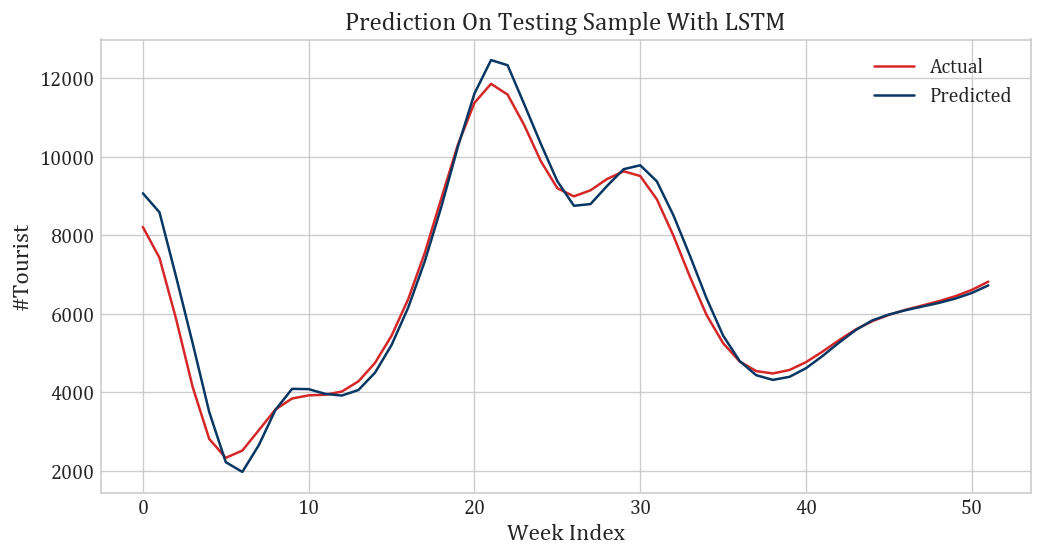

In [15]:
# walk-forward validation on the test data
predictions_test = list()
for i in range(len(test_scaled)):
    # make one-step forecast
    X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
    yhat = forecast_LSTM(LSTM_model, 1, X)
    # invert scaling
    yhat = invert_scale(scaler, X, yhat)
    # invert differencing
    yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
    # store forecast
    predictions_test.append(yhat)
    expected_test = raw_values[len(train) + i + 1]
    print('Week=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected_test))

# report performance
rmse_test = sqrt(mean_squared_error(raw_values[-52:], predictions_test))
print('---------------------------------------------------------------------------')
print('Test RMSE: %.3f' % rmse_test)
print('---------------------------------------------------------------------------')
# line plot of observed vs predicted
plt.plot(raw_values[-52:], label = 'Actual',color='tab:red')
plt.plot(predictions_test, label = 'Predicted',color='#073763ff')
plt.legend(loc='best')
plt.gca().set(title = "Prediction On Testing Sample With LSTM" , 
                  xlabel='Week Index', 
                  ylabel='#Tourist',)
plt.show()